In [1]:
import numpy as np 
import pandas as pd

In [2]:
train_dir="/content/drive/MyDrive/sign_data/train"
train_csv="/content/drive/MyDrive/sign_data/train_data.csv"
test_csv="/content/drive/MyDrive/sign_data/test_data.csv"
test_dir="/content/drive/MyDrive/sign_data/test"
df_train=pd.read_csv(train_csv)
df_train.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
17718,013/12_013.png,013_forg/04_0113013.PNG,1
8581,001/001_18.PNG,001_forg/0201001_02.png,1
11283,003/003_05.PNG,003/003_22.PNG,0
1646,045/12_045.png,045/10_045.png,0
9296,006/006_17.PNG,006_forg/0205006_03.png,1
20198,063/11_063.png,063/09_063.png,0
22937,066/02_066.png,066/09_066.png,0
20391,056/05_056.png,056_forg/02_0115056.PNG,1
18882,015/015_22.PNG,015/015_12.PNG,0
4900,012/012_01.PNG,012/012_14.PNG,0


In [3]:
df_test=pd.read_csv(test_csv)
df_test.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
2998,057/06_057.png,057_forg/04_0117057.PNG,1
4415,063/09_063.png,063/05_063.png,0
3055,057/03_057.png,057_forg/02_0208057.PNG,1
1312,051/12_051.png,051_forg/03_0104051.PNG,1
2453,053/10_053.png,053_forg/04_0115053.PNG,1
751,058/03_058.png,058/02_058.png,0
4484,056/09_056.png,056_forg/01_0115056.PNG,1
1697,050/12_050.png,050/01_050.png,0
4259,063/12_063.png,063_forg/03_0108063.PNG,1
4397,063/12_063.png,063/06_063.png,0


In [4]:
df_train.shape

(23205, 3)

In [5]:
df_test.shape

(5747, 3)

In [6]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os

In [7]:
class Dataset(Dataset):
    #default constuctor for assigning values
    def __init__(self,train_dir=None,train_csv=None,transform=None):
        self.train_dir=train_dir
        self.train_data=pd.read_csv(train_csv)
        self.train_data.columns=['image1','image2','class']
        self.transform=transform
        
    def __getitem__(self,idx): ## __getitem__ returns a sample data given index, idx=index
        
        img1_path=os.path.join(self.train_dir,self.train_data.iat[idx,0])
        img2_path=os.path.join(self.train_dir,self.train_data.iat[idx,1])
        
        img1=Image.open(img1_path)
        img2=Image.open(img2_path)
        
        img1=img1.convert('L') #L mode image, that means it is a single channel image - normally interpreted as greyscale.
        img2=img2.convert('L')
        
        img1=self.transform(img1)
        img2=self.transform(img2)
        
        return img1, img2, torch.from_numpy(np.array([int(self.train_data.iat[idx,2])],dtype=np.float32))
    
    
    def __len__(self): ## __len__ returns the size of the dataset..
        return len(self.train_data)

In [8]:
dataset = Dataset(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

In [9]:
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        
        self.conv1=nn.Conv2d(1,50,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
         # L1 ImgIn shape=(?, 28, 28, 1)      # (n-f+2*p/s)+1
        #    Conv     -> (?, 24, 24, 50)
        #    Pool     -> (?, 12, 12, 50)
        
        
        self.conv2 = nn.Conv2d(50,60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L2 ImgIn shape=(?, 12, 12, 50)
        #    Conv      ->(?, 8, 8, 60)
        #    Pool      ->(?, 4, 4, 60)
        
        
        self.conv3 = nn.Conv2d(60, 80,  kernel_size = 3)
        # L3 ImgIn shape=(?, 4, 4, 60)
        #    Conv      ->(?, 2, 2, 80)
       
        
        
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(60)
        
#         self.dropout1 = nn.Dropout2d()
        
        # L4 FC 2*2*80 inputs -> 250 outputs
        self.fc1 = nn.Linear(32000, 128) 
        self.fc2 = nn.Linear(128, 2)
        
      
    
    
    def forward1(self,x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x=self.pool1(x)
        
        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x=self.pool2(x)
        
        x=self.conv3(x)
        x=F.relu(x)

        x = x.view(x.size()[0], -1)
#32000 thats why the input of fully connected layer is 32000
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward1(input1)
        # forward pass of input 2
        output2 = self.forward1(input2)
        
        return output1, output2

In [10]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
    
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()               
optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4) 

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)
def train():
    loss= [] 

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())
        
    return net

In [12]:
model = train()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1
 Current loss 0.7510090470314026

Epoch 2
 Current loss 0.9005692601203918

Epoch 3
 Current loss 0.76553875207901

Epoch 4
 Current loss 0.5593072175979614

Epoch 5
 Current loss 0.746916651725769

Epoch 6
 Current loss 0.7226471304893494

Epoch 7
 Current loss 0.871753454208374

Epoch 8
 Current loss 0.4369734227657318

Epoch 9
 Current loss 0.6807177066802979



In [13]:
torch.save(model.state_dict(), "model.pt")

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [15]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [16]:
test_dataset = Dataset(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


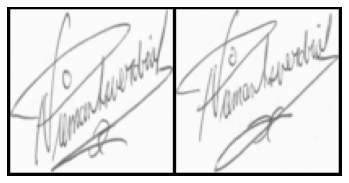

Predicted Eucledian Distance:- 1.2261967658996582
Actual Label:- Original Pair Of Signature


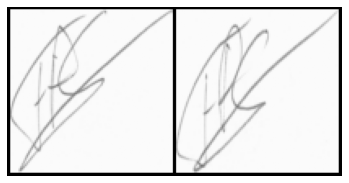

Predicted Eucledian Distance:- 0.4391210675239563
Actual Label:- Original Pair Of Signature


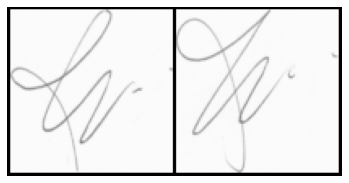

Predicted Eucledian Distance:- 0.729905903339386
Actual Label:- Original Pair Of Signature


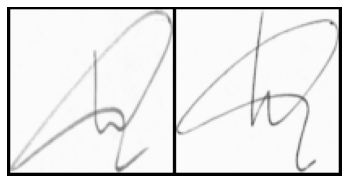

Predicted Eucledian Distance:- 0.7415584921836853
Actual Label:- Forged Pair Of Signature


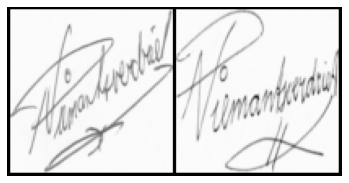

Predicted Eucledian Distance:- 0.7957349419593811
Actual Label:- Forged Pair Of Signature


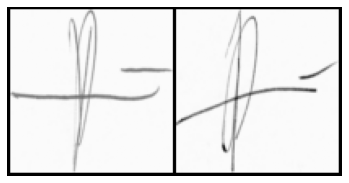

Predicted Eucledian Distance:- 0.4188533127307892
Actual Label:- Forged Pair Of Signature


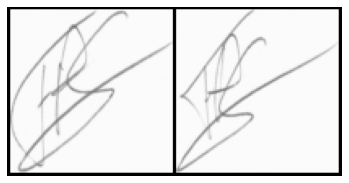

Predicted Eucledian Distance:- 0.39988625049591064
Actual Label:- Original Pair Of Signature


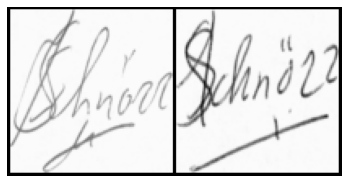

Predicted Eucledian Distance:- 0.6994088888168335
Actual Label:- Forged Pair Of Signature


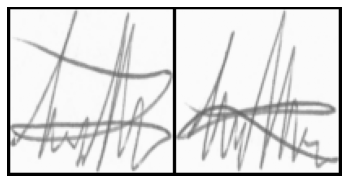

Predicted Eucledian Distance:- 0.8147690892219543
Actual Label:- Original Pair Of Signature


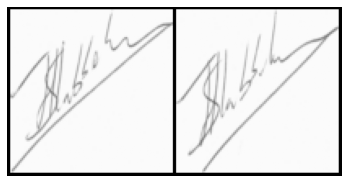

Predicted Eucledian Distance:- 0.9178368449211121
Actual Label:- Original Pair Of Signature


In [17]:
count=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)
    
  if label==torch.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"
    
  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
     break